In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
dataset = pd.read_csv("dados_Brazil_GDP_Electricity.csv", index_col=1)

In [3]:
dataset = dataset.drop(dataset.columns[0], axis=1)

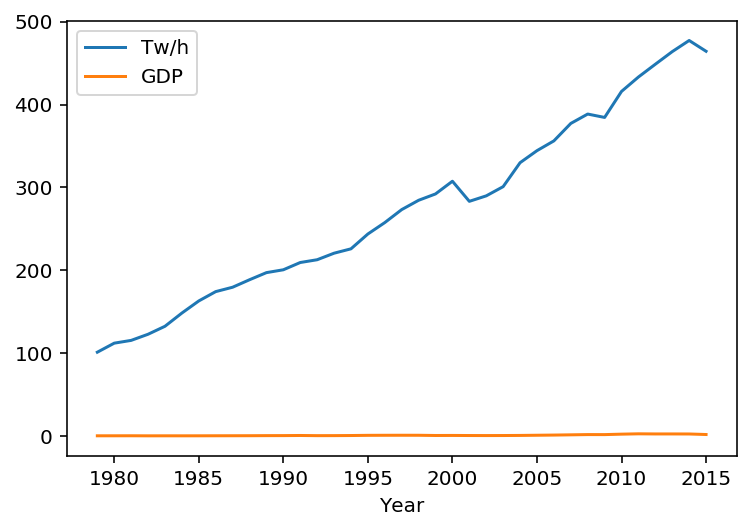

In [4]:
dataset.plot()
_=plt.show()

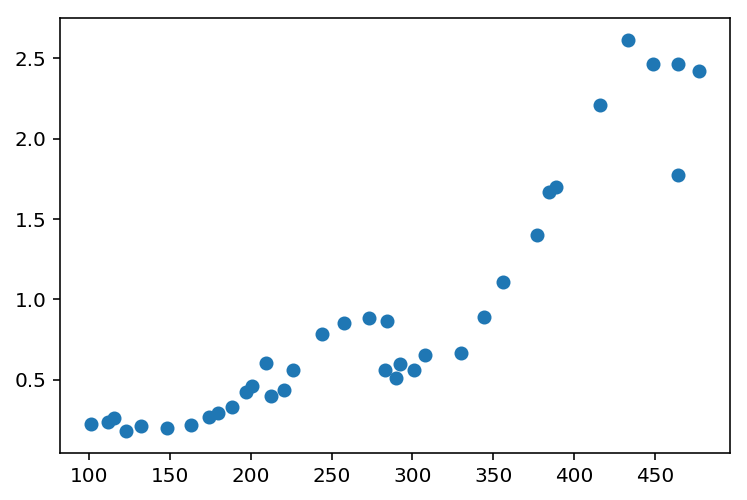

In [5]:
plt.scatter(x=dataset.iloc[:,0], y=dataset.iloc[:,1])
_=plt.show()

In [6]:
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import math
import os

Using TensorFlow backend.


In [7]:
data = dataset.iloc[:,0].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
data = scaler.fit_transform(data)

In [8]:
NUM_TIMESTEPS = 5
max_elements = len(data) - NUM_TIMESTEPS - 1
X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]

In [9]:
X = np.expand_dims(X, axis=2)
#X = X.reshape(X.shape[0], X.shape[1], 1)

X = X[:max_elements]
Y = Y[:max_elements]

In [10]:
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(25, 5, 1) (6, 5, 1) (25, 1) (6, 1)


In [11]:
NUM_EPOCHS = 250
BATCH_SIZE = 5 

np.random.seed(123456)

# stateless
def build_model_stateless():
    model = Sequential()
    model.add(LSTM(10, input_shape=(NUM_TIMESTEPS, 1), return_sequences=False))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
    return model

In [12]:
model_stateless = build_model_stateless()

early_stopping = EarlyStopping(patience=2)
history = model_stateless.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(Xtest, Ytest), shuffle=False, callbacks=[early_stopping], verbose=0)

W0709 21:07:08.603758 31532 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 21:07:08.695510 31532 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 21:07:08.721440 31532 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 21:07:09.199162 31532 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 21:07:09.565101 31532 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add

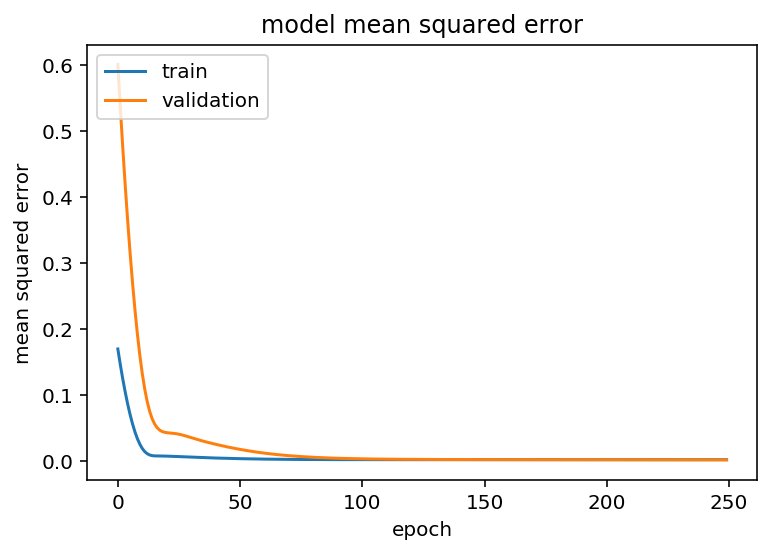

In [13]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

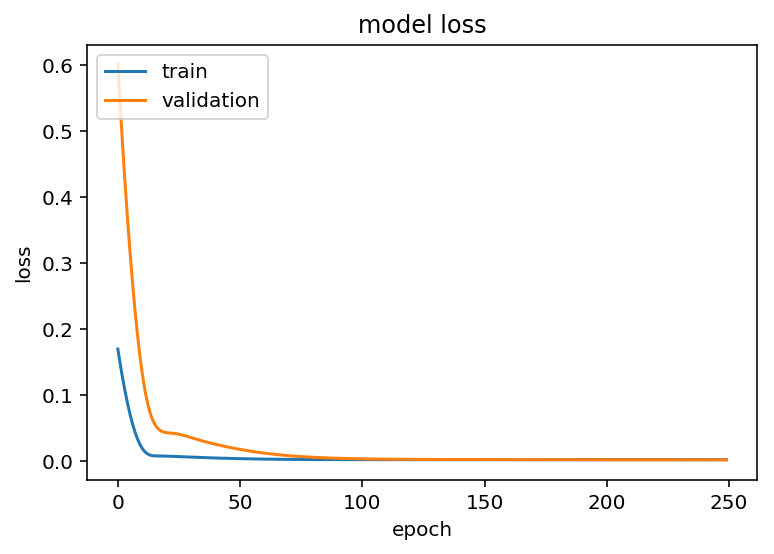

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
_=plt.show()

In [15]:
test_length = NUM_TIMESTEPS
dataset_train = dataset.iloc[0:-test_length,:]

In [18]:
last_point = dataset_train.iloc[-NUM_TIMESTEPS:, 0].values.reshape(1, NUM_TIMESTEPS)
last_point_scaled = scaler.transform(last_point)
last_point_scaled = last_point_scaled.reshape(1, NUM_TIMESTEPS, 1)

In [19]:
num_predictions = test_length + 10
year_ini = dataset_train.index[-1] + 1 

In [20]:
last_x = last_point_scaled
predictions = []
years = []
for i in range(num_predictions):
    pred_tmp = model_stateless.predict(last_x)
    pred = scaler.inverse_transform(pred_tmp)
    predictions.append(pred[0][0])
    years.append(year_ini+i)
    next_x = np.roll(last_x, 1)
    next_x[0,0] = pred_tmp
    last_x = next_x

predictions_df = pd.DataFrame({'Forecast':predictions}, index=years) 

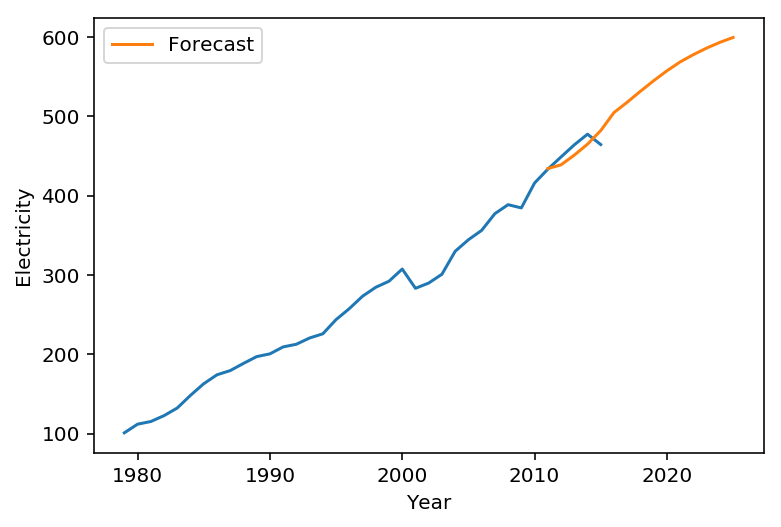

In [21]:
ax = dataset.iloc[:,0].plot()
predictions_df.plot(ax=ax)
plt.ylabel("Electricity")
plt.show()

In [22]:
predictions_df.iloc[:test_length,:]

,Forecast
2011,434.102203
2012,438.823364
2013,451.048645
2014,464.841003
2015,482.018005


In [23]:
dataset.iloc[-test_length:, 0].values


array([433.324, 448.76 , 463.978, 477.424, 464.402])

In [24]:
pred_errors = dataset.iloc[-test_length:, 0].values - predictions_df.iloc[:test_length,0].values

In [25]:
np.sqrt(np.mean(pred_errors**2))

12.125724710593154